In [16]:
!hostname

gl1012.arc-ts.umich.edu


In [17]:
import os
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from anatomix.model.network import Unet
import gc
import glob
from torch.nn import functional as F

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


# 1. Load SynthRAD2025 Dataset

In [19]:
# def create_synthrad_dataset(root_dir):
#     subjects = []
#     for anatomy in sorted(os.listdir(root_dir)):
#         anatomy_path = os.path.join(root_dir, anatomy)
#         if not os.path.isdir(anatomy_path):
#             continue

#         for patient in sorted(os.listdir(anatomy_path)):
#             patient_path = os.path.join(anatomy_path, patient)
#             if not os.path.isdir(patient_path):
#                 continue

#             mr_path = os.path.join(patient_path, "mr.mha")
#             ct_path = os.path.join(patient_path, "ct.mha")
#             mask_path = os.path.join(patient_path, "mask.mha")

#             if not (os.path.exists(mr_path) and os.path.exists(ct_path)):
#                 continue

#             subject = tio.Subject(
#                 id=patient,
#                 anatomy=anatomy,
#                 mr=tio.ScalarImage(mr_path),
#                 ct=tio.ScalarImage(ct_path),
#                 mask=tio.LabelMap(mask_path),
#             )
#             subjects.append(subject)
#     return tio.SubjectsDataset(subjects)

# root = "/Users/ms/cs/ML/MRI2CT/SynthRAD2025/Task1"
# dataset = create_synthrad_dataset(root)
# print(f"Loaded {len(dataset)} subjects")

# # Pick one subject to visualize
# subject = dataset[0]
# mri = subject["mr"].data[0].numpy()  # [H, W, D]
# ct = subject["ct"].data[0].numpy()
# print("MRI shape:", mri.shape)
# print("CT shape:", ct.shape)

# # Normalize intensity
# mri = (mri - mri.min()) / (mri.max() - mri.min())

# # Select one representative slice (e.g., middle axial)
# slice_z = mri.shape[-1] // 2

In [20]:
def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None and maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr


def find_image(root, subj_id, name):
    # base = os.path.join(root, subj_id.replace("_", "/"))
    base = os.path.join(root, subj_id)
    matches = glob.glob(os.path.join(base, f"{name}.nii*"))
    # matches = glob.glob(os.path.join(base, f"{name}.mha")) + glob.glob(
    #     os.path.join(base, f"{name}.nii*")
    # )
    if not matches:
        raise FileNotFoundError(f"{name}.nii* file not found for {subj_id}")
    return matches[0]


def load_image_pair(root, subj_id):
    ct_path = find_image(root, subj_id, "ct")
    mr_path = find_image(root, subj_id, "moved_mr*")
    # mr_path = find_image(root, subj_id, "mr")
    # mask_path = find_image(root, subj_id, "mask")

    mr_img = tio.ScalarImage(mr_path)
    ct_img = tio.ScalarImage(ct_path)

    mri = mr_img.data[0].numpy()
    ct = ct_img.data[0].numpy()

    mri = minmax(mri)
    ct = minmax(ct, minclip=-450, maxclip=450)
    print("MRI shape:", mri.shape, "CT shape:", ct.shape)
    return mri, ct


def cleanup_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print("✅ GPU memory cache cleared")

In [21]:
SUBJ_ID = "1ABA005_128x128x128"
mr, ct = load_image_pair("/home/minsukc/MRI2CT/anatomix_registration_outputs", SUBJ_ID)

MRI shape: (128, 128, 128) CT shape: (128, 128, 128)


# 2. Load Anatomix pretrained model

In [22]:
model = Unet(
    dimension=3,
    input_nc=1,
    output_nc=16,  # feature channels
    num_downs=4,
    ngf=16,
).to(device)

ckpt_path = "/home/minsukc/MRI2CT/anatomix/model-weights/anatomix.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device), strict=True)
model.eval()
print("✅ Loaded anatomix pretrained model")

Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
✅ Loaded anatomix pretrained model


# 3. Extract 3D feature maps

In [23]:
def extract_feats(volume_np, model, device):
    with torch.no_grad():
        inp = torch.from_numpy(volume_np[None, None]).float().to(device)

        feats = model(inp)
        feats = feats.squeeze(0).cpu().numpy()  # [C, H, W, D]
    return feats

In [24]:
feats_mr = extract_feats(mr, model, device)
cleanup_gpu()
feats_ct = extract_feats(ct, model, device)
print(f"✅ MRI feats: {feats_mr.shape}, CT feats: {feats_ct.shape}")
C, H, W, D = feats_mr.shape

✅ GPU memory cache cleared
✅ MRI feats: (16, 128, 128, 128), CT feats: (16, 128, 128, 128)


# 4. Select one slice for 2D visualization

In [25]:
feat_slice = feats_mr[:, :, :, D // 2]  # [C, H, W]
feat_slice = np.transpose(feat_slice, (1, 2, 0))  # [H, W, C]
# H, W, C = feat_slice.shape
print(f"Feature slice: {H}x{W}, {C} channels")

Feature slice: 128x128, 16 channels


# 5. PCA Feature Visualization

In [26]:
# 4. Shared PCA basis (so MRI/CT use same 3D color space)
C, H, W, D = feats_mr.shape


# stack both features, sample to avoid memory blow-up
def sample_vox(feats, max_vox=200_000):
    X = feats.reshape(C, -1).T
    if X.shape[0] > max_vox:
        idx = np.random.choice(X.shape[0], max_vox, replace=False)
        X = X[idx]
    return X


X_m = sample_vox(feats_mr)
X_c = sample_vox(feats_ct)
X_both = np.concatenate([X_m, X_c], axis=0)

pca = PCA(n_components=3, svd_solver="randomized")
pca.fit(X_both)
print("✅ Shared PCA basis fitted on MRI+CT features")


# project both modalities into the same PCA space
def project_pca(feats, pca):
    X = feats.reshape(C, -1).T
    Y = pca.transform(X)
    # min-max normalize each channel for visualization
    Ymin, Ymax = Y.min(0, keepdims=True), Y.max(0, keepdims=True)
    Yn = (Y - Ymin) / (Ymax - Ymin + 1e-8)
    return Yn.reshape(H, W, D, 3)


pca_mri = project_pca(feats_mr, pca)
pca_ct = project_pca(feats_ct, pca)

✅ Shared PCA basis fitted on MRI+CT features


# 6. Patch-wise Similarity Map

In [27]:
# Full C-dim cosine similarity & l2 dist (voxel-wise MRI↔CT)
m3 = torch.from_numpy(feats_mr).unsqueeze(0)  # [1,C,H,W,D]
c3 = torch.from_numpy(feats_ct).unsqueeze(0)  # [1,C,H,W,D]
m3 = F.normalize(m3, dim=1)
c3 = F.normalize(c3, dim=1)
cos_sim = (m3 * c3).sum(dim=1).squeeze(0).numpy()  # [H,W,D], in [-1,1]
# normalize for display
cos_sim_n = (cos_sim - cos_sim.min()) / (cos_sim.max() - cos_sim.min())
print("✅ Computed full C-dim cosine similarity")

# L2 distance
l2_dist = torch.norm(
    torch.from_numpy(feats_mr) - torch.from_numpy(feats_ct), dim=0
).numpy()
l2_dist_n = (l2_dist - l2_dist.min()) / (l2_dist.max() - l2_dist.min())
l2_dist_n_inv = 1 - l2_dist_n  # invert so high = similar
print("✅ Computed full 3D cosine similarity and L2 distance")


✅ Computed full C-dim cosine similarity
✅ Computed full 3D cosine similarity and L2 distance


# Visualization

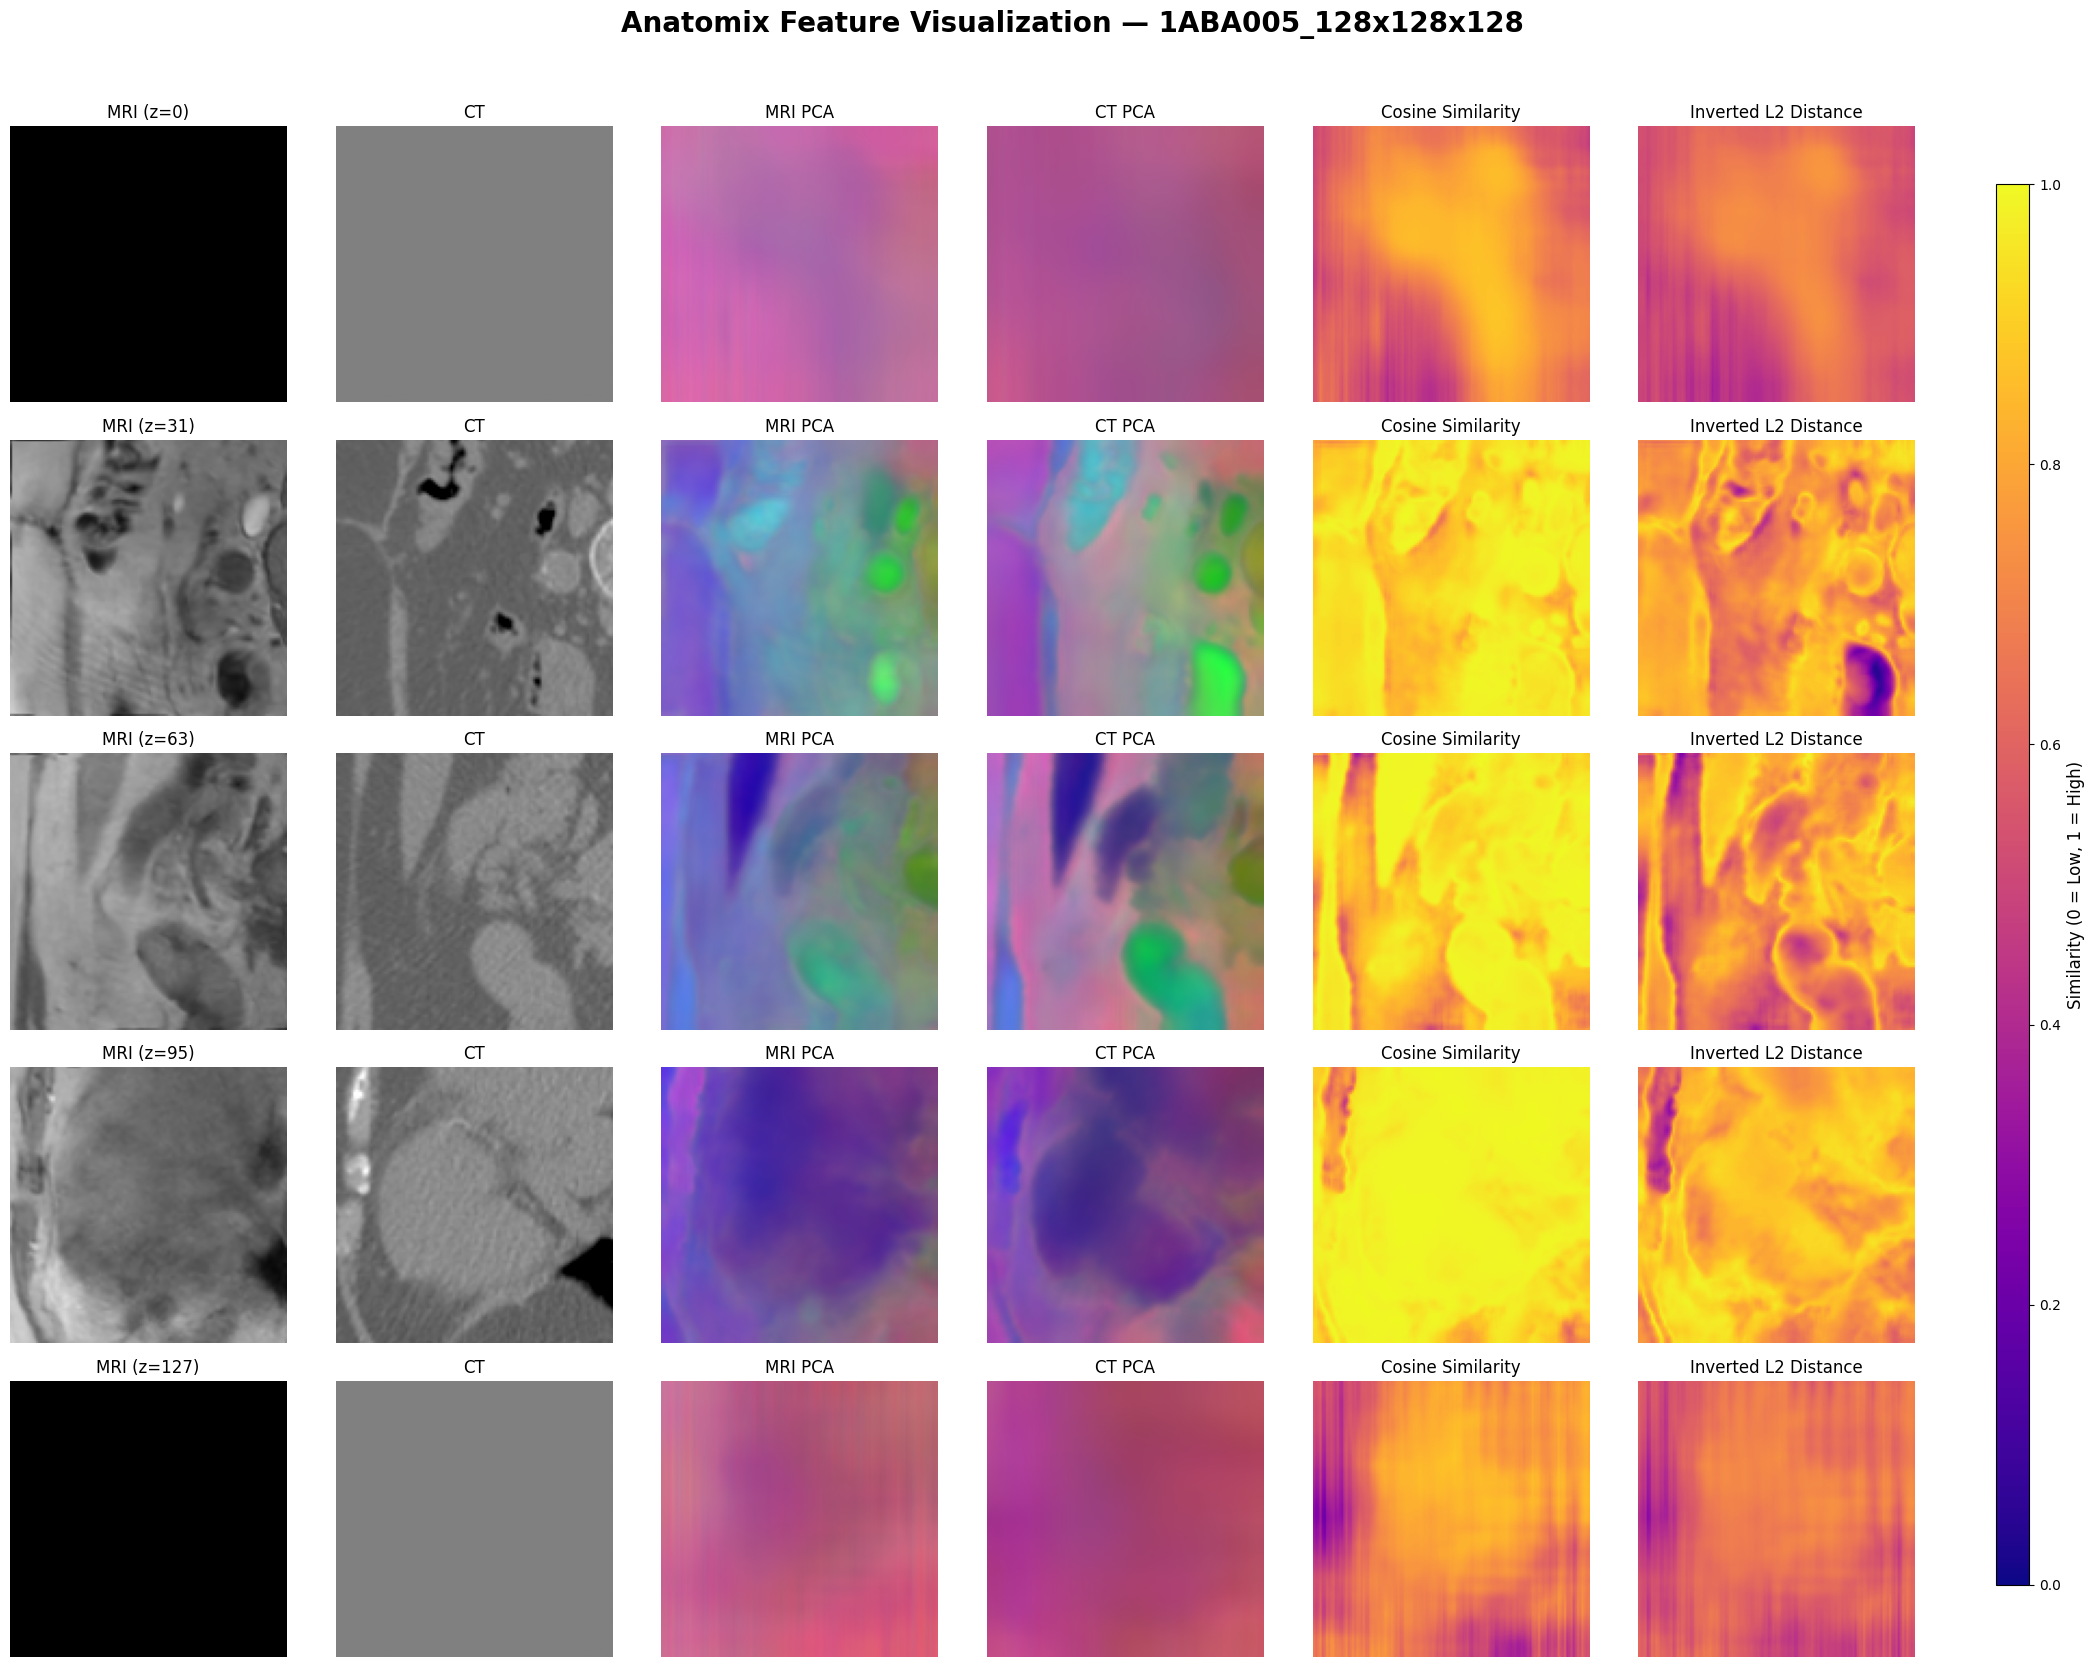

In [33]:
import matplotlib as mpl

# =========================================
# Visualization: Original + PCA + Similarity
# =========================================
num_slices = 5
slice_indices = np.linspace(0, D - 1, num_slices, dtype=int)

vmin, vmax = 0.0, 1.0  # shared normalization for similarity maps

# Create figure: MRI | CT | MRI PCA | CT PCA | CosSim | Inv L2
fig, axes = plt.subplots(num_slices, 6, figsize=(22, 3.5 * num_slices))

for i, z in enumerate(slice_indices):
    # --- MRI ---
    axes[i, 0].imshow(mr[:, :, z], cmap="gray", vmin=0, vmax=1)
    axes[i, 0].set_title(f"MRI (z={z})")
    axes[i, 0].axis("off")

    # --- CT ---
    axes[i, 1].imshow(ct[:, :, z], cmap="gray", vmin=0, vmax=1)
    axes[i, 1].set_title("CT")
    axes[i, 1].axis("off")

    # --- PCA MRI ---
    axes[i, 2].imshow(pca_mri[:, :, z, :])
    axes[i, 2].set_title("MRI PCA")
    axes[i, 2].axis("off")

    # --- PCA CT ---
    axes[i, 3].imshow(pca_ct[:, :, z, :])
    axes[i, 3].set_title("CT PCA")
    axes[i, 3].axis("off")

    # --- Cosine similarity ---
    im_cos = axes[i, 4].imshow(cos_sim_n[:, :, z], cmap="plasma", vmin=vmin, vmax=vmax)
    axes[i, 4].set_title("Cosine Similarity")
    axes[i, 4].axis("off")

    # --- Inverted L2 distance ---
    axes[i, 5].imshow(l2_dist_n_inv[:, :, z], cmap="plasma", vmin=vmin, vmax=vmax)
    axes[i, 5].set_title("Inverted L2 Distance")
    axes[i, 5].axis("off")

# === Single shared colorbar ===
# Use the last similarity image handle (im_cos)
cbar_ax = fig.add_axes([0.92, 0.05, 0.015, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(im_cos, cax=cbar_ax)
cbar.set_label("Similarity (0 = Low, 1 = High)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.suptitle(
    f"Anatomix Feature Visualization — {SUBJ_ID}",
    fontsize=20,
    y=0.95,
    fontweight="bold",
)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])  # leave space for colorbar
plt.show()
